In [1]:
import numpy as np
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, ttest_ind, zscore, pearsonr, wilcoxon
import pybedtools as pbt
from scipy.integrate import simps
from IPython.display import clear_output

plt.style.use('fivethirtyeight')
def clean_axis(ax):
    ax.xaxis.set_tick_params(labelsize=9)
    ax.yaxis.set_tick_params(labelsize=9)
    for i in ['top', 'bottom', 'left', 'right']:
        ax.spines[i].set_visible(False)
    ax.grid(which='major', linestyle='--', alpha=0.5)
    return True

In [2]:
chroms = ['chr'+str(x) for x in range(1,23)] + ['chrX', 'chrY']
chrom_info = [x.rstrip('\n').split('\t') for x in 
              open('/home/parashar/scratch/hg19_resource/hg19.genome').readlines()]
chrom_info = {x[0]: int(x[1]) for x in chrom_info}

In [166]:
def get_span_exp_score(chrom, start, end, strand, score_type='exp'):
    strand = 'positive' if strand == '+' else 'negative'
    fn = int((int(start/1e6) + 1) * 1e6)
    if end > fn:
        print ("End not in data block")
        return False
    if score_type == 'exp':
        exp = np.load('../data/quad_graph_single_base_scores/%s/%s/%s_exp_score.npy' %
                 (chrom, strand, fn))
    else:
        exp = np.load('../data/quad_graph_single_base_scores/%s/%s/%s_delta_score.npy' %
                 (chrom, strand, fn))
    exp_array = np.zeros(int(1e6)+10000)
    start_mb = int(int(start/1e6) * 1e6)
    for i in exp:
        exp_array[int(i[0])-start_mb] = i[1]
    res_start = start - start_mb
    res_end = end - start_mb
    score = np.array([2**(-1/x) if x !=0 else 0 for x in exp_array[res_start:res_end]])
    return score

In [250]:
promoters = {
    'cKIT': ('chr4', 55523995, 55524195, '+'),
    'PDGFRB': ('chr5', 149535322, 149535522, '-'),
    'TERT': ('chr5', 1295062, 1295262, '-'),
    'MYB': ('chr6', 135502353, 135502553, '+'),
    'BRAF': ('chr7', 140624464, 140624664, '-'),
    'cMYC': ('chr8', 128748215, 128748415, '+'),
    'NME2': ('chr17', 49244092, 49244292, '+'),
    'SP1': ('chr12', 53773879, 53774079, '+'),
    'HIF1A': ('chr14', 62162019, 62162219, '+'),
    'KRAS': ('chr12', 25403765, 25403965, '-'),
}

for i in promoters:
    x = list(promoters[i])
    x[1] = x[1] - 900
    x[2] = x[2] + 900
    promoters[i] = x

In [283]:
g4_promoters = {}
for i in promoters:
    v = promoters[i]
    bedline = "\t".join(map(str, [v[0], v[1] ,v[2], i, '0', v[3]]))
    bed = pbt.BedTool(bedline, from_string=True)
    g4 = pbt.BedTool('/home/parashar/scratch/quadruplexes/hg19/g3_7_0_%s_nov.bed' % v[0])
    intersect = bed.intersect(g4, wo=True)
    sense = []
    antisense = []
    for l in intersect:
        c = str(l).rstrip('\n').split('\t')
        s = max(0, int(c[7]) - int(c[1]))
        e = int(c[8]) - int(c[1])
        g4_strand = '+' if c[10][0] == 'G' else '-'
        if g4_strand == c[5]:
            if c[5] == '+':
                sense.append([s, e])
            else:
                sense.append([2000-e, 2000-s])
        else:
            if c[5] == '+':
                antisense.append([s, e])
            else:
                antisense.append([2000-e, 2000-s])
    g4_promoters[i] = [sense, antisense]

In [282]:
g4_promoters

{'BRAF': [[], [[1024, 1005], [825, 795]]],
 'HIF1A': [[], [[1034, 1055], [1469, 1495]]],
 'KRAS': [[[1346, 1314], [1312, 1284]],
  [[1598, 1575], [1228, 1207], [883, 855], [837, 812]]],
 'MYB': [[[191, 218], [648, 675], [1226, 1251]], [[736, 761]]],
 'NME2': [[[494, 511], [520, 546]], [[1237, 1260]]],
 'PDGFRB': [[[1810, 1784]], [[1515, 1492], [913, 882]]],
 'SP1': [[[1236, 1264]],
  [[1036, 1058], [1333, 1352], [1536, 1563], [1575, 1602]]],
 'TERT': [[[1941, 1915]], [[959, 931], [928, 902]]],
 'cKIT': [[[906, 926], [956, 978]], []],
 'cMYC': [[[87, 114]], [[853, 884], [1300, 1322]]]}

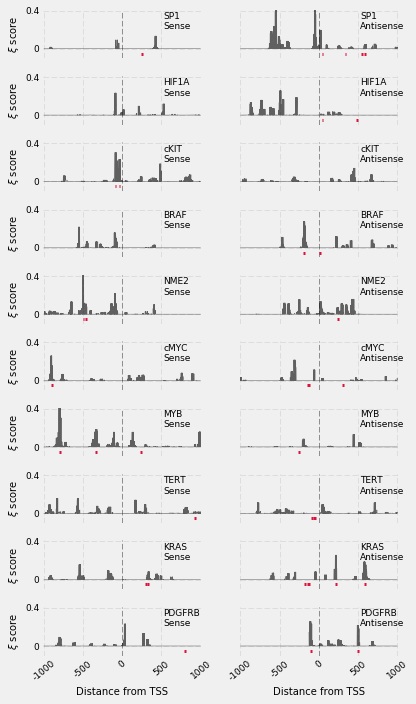

In [322]:
fig, axis = plt.subplots(10, 2, figsize=(6, 10))
for row,gene in enumerate(promoters):
    strand = promoters[gene][3]
    sense = get_span_exp_score(promoters[gene][0], promoters[gene][1],
                               promoters[gene][2], strand)
    antistrand = '+' if strand == '-' else '-'
    antisense = get_span_exp_score(promoters[gene][0], promoters[gene][1],
                                   promoters[gene][2], antistrand)
    if strand == '-':
        sense = sense[::-1]
        antisense = antisense[::-1]
    promoter_exp = [sense, antisense]
    
    for col in [0, 1]:
        ax = axis[row, col]
        ax.plot(list(range(2000)), promoter_exp[col], lw=0.5, alpha=0.6, color='k')
        ax.axvline(1000, ls='--', color='k', alpha=0.7, lw=0.5)
        print_strand = '%s\nSense' % gene if col == 0 else '%s\nAntisense' % gene
        ax.text(0.76, 0.6, print_strand, transform=ax.transAxes, fontsize=9)
        for g4_span in g4_promoters[gene][col]:
            r = list(range(g4_span[0], g4_span[1]))
            ax.plot(r, [-0.05 for x in range(r[-1] - r[0] + 1)], lw=3, color='crimson')

        for j in ['top', 'bottom', 'left', 'right']:
            ax.spines[j].set_visible(False)
        ax.grid(which='major', linestyle='--', alpha=0.5)
        ax.set_yticks([0, 0.4])
        if col == 1:
            ax.set_yticklabels([])
        else:
            ax.set_yticklabels([0, 0.4])
            ax.set_ylabel(r'$\xi$' + ' score', fontsize=10)
        ax.set_xticks([0, 500, 1000, 1500, 2000])
        if row == 9:
            ax.set_xticklabels([-1000, -500, 0, 500, 1000], rotation=40, fontsize=9)
            ax.set_xlabel('Distance from TSS', fontsize=10)
        else:
            ax.set_xticklabels([])
        ax.xaxis.set_tick_params(labelsize=9)
        ax.yaxis.set_tick_params(labelsize=9) 
        ax.set_xlim(-10, 2010)
        ax.set_ylim((-0.1, 0.41))
plt.savefig('../images/promoters_blow_out.png', dpi=300, transparent=True, edgecolor='none')
plt.savefig('../images/promoter_blow_out.svg', transparent=True, edgecolor='none')
plt.tight_layout()
plt.show()

In [224]:
chr5 = ''.join([x.rstrip('\n') for x in
        open('/home/parashar/scratch/hg19_resource/chromosomes/chr5.fa').readlines()[1:]])

In [225]:
len(chr5)

180915260

In [233]:
pdgfr_seq = np.array(list(chr5[149534422:149536422].upper()))

In [235]:
pdgfr_seq.shape

(2000,)

In [237]:
pdgfr_seq[sense > 0]

array(['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C',
       'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C

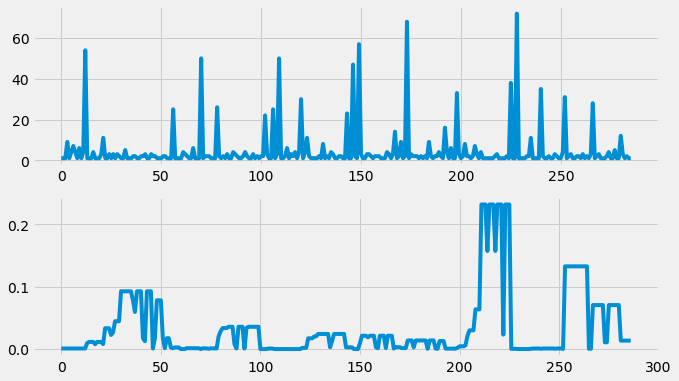

In [248]:
fig, axis = plt.subplots(2, 1, figsize=(10, 6))

axis[0].plot(np.diff(np.array(np.where(sense > 0)[0], dtype=int)))
axis[1].plot(sense[sense > 0])
plt.show()